<a href="https://colab.research.google.com/github/DemianDeveloper/Machine_Learning/blob/main/trade_range_bnb_xvg_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*анализ эффективности моделей машинного обучения (ML) для торговли монетами, находящимися в рэндже, а не двигающимися в тренде.*

подберём оптимальные индикаторы на монетах, когда они находиться в рэнже.

# дерево решений и случайный лес
проверим гипотезу смогут ли ML модели дерево решений и случайный лес обученные на подобранных индикатора торговать внутри бокового коридора цены

для проверки гипотзы выгрузили данные монет BNB, XVG, SOL

используемые индикаторы: RSI, SMA, DMI

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from google.colab import files

In [5]:
file_bnb = files.upload()

Saving bnb-15min.csv to bnb-15min.csv


In [6]:
file_xvg = files.upload()

Saving xvg-15min.csv to xvg-15min.csv


In [7]:
file_sol = files.upload()

Saving sol-15min.csv to sol-15min.csv


In [8]:
data_bnb = pd.read_csv('bnb-15min.csv')

In [9]:
data_xvg = pd.read_csv('xvg-15min.csv')

In [10]:
data_sol = pd.read_csv('sol-15min.csv')

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import talib
from talib import abstract

In [13]:
# Подготовка данных монеты BNB

df_prices_bnb = data_bnb[['date_time', 'open', 'high', 'low', 'close', 'volume']]
df_prices_bnb.set_index('date_time', inplace=True)
df_prices_bnb

,open,high,low,close,volume
date_time,,,,,
2023-07-24 07:30:00,240.00,240.00,239.95,240.00,727.60
2023-07-24 07:45:00,240.00,242.05,239.95,242.00,88.54
2023-07-24 08:00:00,242.00,242.05,241.85,242.05,122.61
2023-07-24 08:15:00,242.05,242.05,241.65,242.05,133.38
2023-07-24 08:30:00,242.05,242.10,241.70,242.10,120.97
...,...,...,...,...,...
2024-03-20 22:00:00,555.00,559.50,555.00,558.50,1836.71
2024-03-20 22:15:00,558.50,559.00,554.00,555.50,4869.03
2024-03-20 22:30:00,555.50,557.00,554.50,554.50,17442.56


<function matplotlib.pyplot.show(close=None, block=None)>

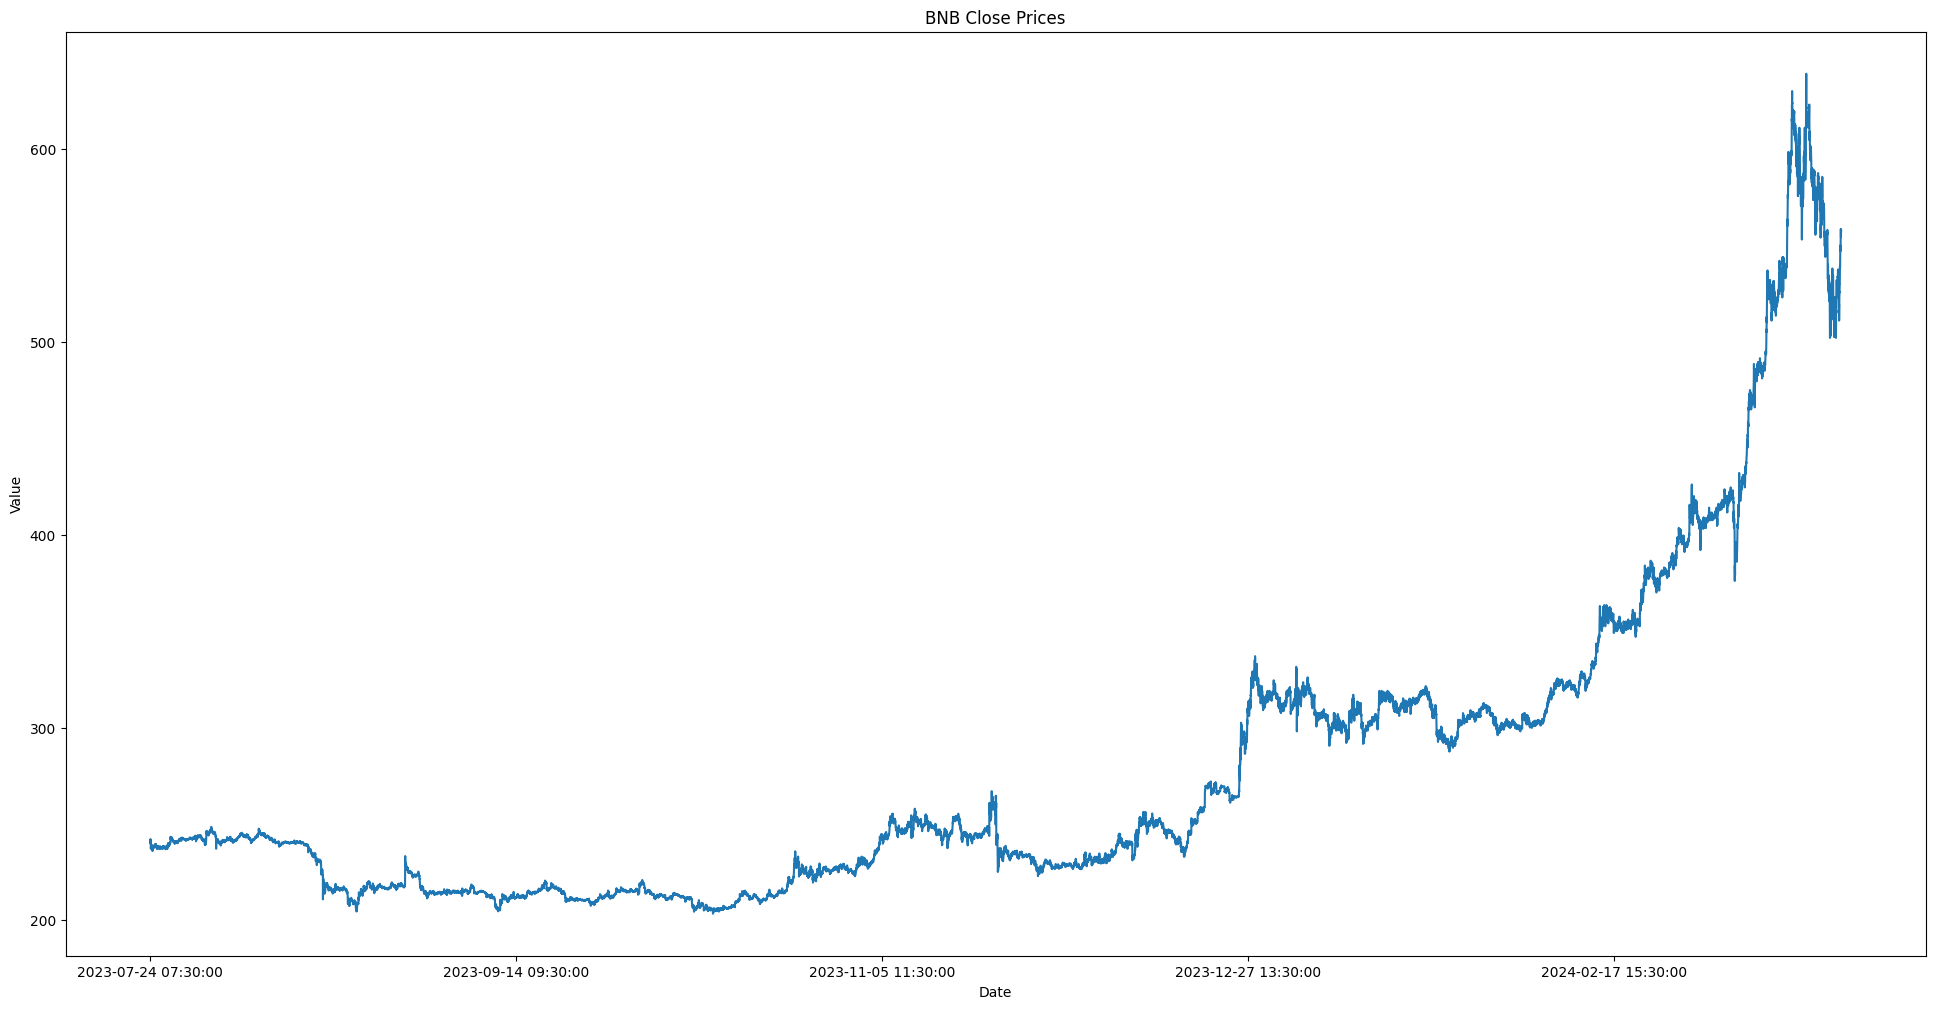

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
df_prices_bnb['close'].plot(ax=axes, title='BNB Close Prices', xlabel='Date', ylabel='Value')
plt.show

In [15]:
# Определение функции для вычисления технических индикаторов
def indicators(df):
  df['rsi'] = abstract.RSI(df)
  df['dmi'] = abstract.DX(df)
  df['sma'] = abstract.SMA(df)
  return df

In [16]:
# Применение функции для вычисления индикаторов
df_prices_bnb_indicators = indicators(df_prices_bnb)
df_prices_bnb_indicators.dropna(inplace=True)

In [17]:
# Выделение индикаторов в отдельный DataFrame
df_bnb_indicators = df_prices_bnb_indicators[['rsi', 'sma', 'dmi']]
df_bnb_indicators

,rsi,sma,dmi
date_time,,,
2023-07-24 14:45:00,35.502621,239.441667,42.059339
2023-07-24 15:00:00,28.906734,239.310000,60.114834
2023-07-24 15:15:00,40.361703,239.151667,60.114834
2023-07-24 15:30:00,35.486866,238.960000,60.114834
2023-07-24 15:45:00,40.384248,238.788333,60.114834
...,...,...,...
2024-03-20 22:00:00,78.485796,533.700000,55.903985
2024-03-20 22:15:00,71.787137,534.716667,51.115948
2024-03-20 22:30:00,69.653106,535.616667,51.115948


In [18]:
# Функция для построения корреляционной матрицы. проверяем есть ли связь между индексами
def corr_matrix(df):

    # Вычисляем корреляционную матрицу с использованием метода Пирсона
    corr_df = df.corr(method='pearson')

    # Создаем объект "фигура" для рисования
    plt.figure(figsize=(9, 5))

    # Строим тепловую карту корреляционной матрицы с аннотациями
    sns.heatmap(corr_df, cmap='bwr', annot=True)

    # Показываем график
    plt.show()

на графике видно, что связь между индексами отсутсвует
т.е. каждый индикатор будте приносить для модели собственную информацию

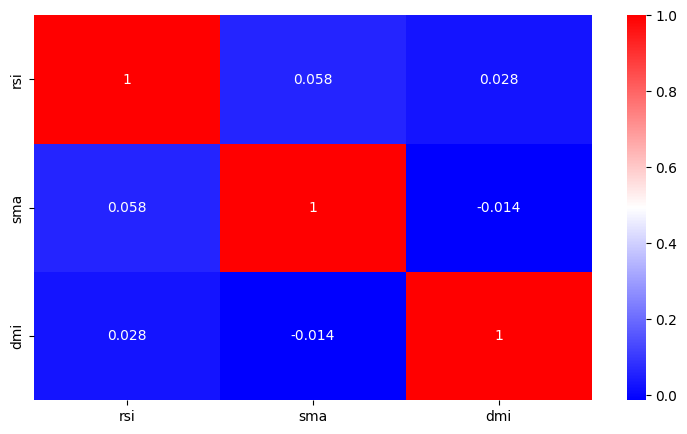

In [19]:
corr_matrix(df_bnb_indicators)#вызываем функцию

In [20]:
#приводим данные к одному временному стандарту, чтобы они по-одинаковому влияли на модель
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
scaled_bnb_indicators = scaler.fit_transform(df_bnb_indicators)
X_bnb = pd.DataFrame(scaled_bnb_indicators, columns=df_bnb_indicators.columns, index=df_bnb_indicators.index)
X_bnb

,rsi,sma,dmi
date_time,,,
2023-07-24 14:45:00,-1.447743,-0.452139,0.900961
2023-07-24 15:00:00,-2.074516,-0.453710,1.878844
2023-07-24 15:15:00,-0.986009,-0.455600,1.878844
2023-07-24 15:30:00,-1.449240,-0.457887,1.878844
2023-07-24 15:45:00,-0.983867,-0.459936,1.878844
...,...,...,...
2024-03-20 22:00:00,2.636727,3.059921,1.650785
2024-03-20 22:15:00,2.000188,3.072055,1.391465
2024-03-20 22:30:00,1.797402,3.082797,1.391465


решаем бинарную классификацию:
1 - цена идёт вверх /
0 - цена идёт вниз

In [22]:
# Определение целевой переменной для бинарной классификации
bnb_y = np.where(df_prices_bnb_indicators['close'].shift(-1) > df_prices_bnb_indicators['close'], 1, 0)
df_bnb_y = df_prices_bnb_indicators[['close']]
df_bnb_y['y'] = df_bnb_y
df_bnb_y

,close,y
date_time,,
2023-07-24 14:45:00,237.30,237.30
2023-07-24 15:00:00,236.05,236.05
2023-07-24 15:15:00,237.25,237.25
2023-07-24 15:30:00,236.30,236.30
2023-07-24 15:45:00,236.90,236.90
...,...,...
2024-03-20 22:00:00,558.50,558.50
2024-03-20 22:15:00,555.50,555.50
2024-03-20 22:30:00,554.50,554.50


In [23]:
P_bnb = df_bnb_y[['close']]
Y_bnb = df_bnb_y[['y']]

70% - обучаем модель
30% - тестируем модель


In [24]:
# Определяем процент данных для обучения
percent_for_train = 0.7

# Вычисляем количество строк, которые будут использоваться для обучения
split_bnb = int(percent_for_train * len(X_bnb))

# Разделяем данные на обучающие и тестовые
X_train_bnb = X_bnb[:split_bnb]
y_train_bnb = Y_bnb[:split_bnb]
p_train_bnb = P_bnb[:split_bnb]

x_test_bnb = X_bnb[split_bnb:]
y_test_bnb = Y_bnb[split_bnb:]
p_test_bnb = P_bnb[split_bnb:]

bnb_back_test_df = df_bnb_y[split_bnb:]

In [25]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [26]:
from sklearn.tree import DecisionTreeClassifier


фиксируем правило по которому осуществляется рандомизация

In [27]:
RANDOM_STATE = 10

СОЗДАЁМ МОДЕЛЬ

 y_scores = clf.predict_proba(x_test)[:, 1]

 Эта строка кода далее используется для получения оценок вероятности класса "1" для каждого элемента в тестовом наборе данных. В частности, clf.predict_proba(x_test) возвращает вероятности принадлежности каждого элемента тестового набора к каждому классу, а [:, 1] выбирает только вероятности принадлежности к классу "1".

разберем это по частям:

clf.predict_proba(x_test): Этот метод возвращает массив вероятностей принадлежности каждого элемента тестового набора к каждому классу. В случае бинарной классификации (два класса) он возвращает двумерный массив, где каждая строка соответствует одному элементу тестового набора, а столбцы соответствуют вероятностям принадлежности к каждому классу.

[:, 1]: Это синтаксис среза, который используется для выбора элементов из массива. В данном случае [:, 1] выбирает все строки (все элементы тестового набора) и только второй столбец (столбец с индексом 1), который соответствует вероятностям принадлежности к классу "1". Таким образом, y_scores будет содержать только вероятности принадлежности к классу "1" для каждого элемента тестового набора.

Это может быть полезно, например, при рассмотрении кривой ROC (Receiver Operating Characteristic) для оценки производительности классификатора.

In [28]:
# Определяем функцию для обучения и оценки модели
def ML(clf, X_train, x_test, y_train, y_test):
    # Обучаем модель
    clf.fit(X_train, y_train)

    # Получаем прогнозы
    preds = clf.predict(x_test)

    #используется для получения оценок вероятности класса "1" для каждого элемента в тестовом наборе данных
    y_scores = clf.predict_proba(x_test)[:, 1]

    # Вычисляем метрику точности
    acc_score = accuracy_score(y_test, preds)

    return preds, acc_score, y_scores

In [29]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [30]:
# Преобразуем y в бинарные значения
y_train_bnb = np.where(y_train_bnb > y_train_bnb.mean(), 1, 0)
y_test_bnb = np.where(y_test_bnb > y_test_bnb.mean(), 1, 0)

# Обучаем модель и получаем прогнозы
preds_bnb_tree, acc_score_bnb_tree, y_scores_bnb_tree = ML(tree, X_train_bnb, x_test_bnb, y_train_bnb, y_test_bnb)

# Выводим результаты
print('точность предсказаний (accuracy_score):', acc_score_bnb_tree)
print('количество сигналов на покупку:', preds_bnb_tree.sum())


точность предсказаний (accuracy_score): 0.3804708941210458
количество сигналов на покупку: 6922


In [31]:
bnb_back_test_df['pred_Tree'] = preds_bnb_tree
bnb_back_test_df['signal_Tree'] = (bnb_back_test_df['pred_Tree']*2) - 1
bnb_back_test_df

,close,y,pred_Tree,signal_Tree
date_time,,,,
2024-01-08 20:30:00,305.5,305.5,1,1
2024-01-08 20:45:00,305.0,305.0,1,1
2024-01-08 21:00:00,305.5,305.5,1,1
2024-01-08 21:15:00,305.5,305.5,1,1
2024-01-08 21:30:00,306.0,306.0,1,1
...,...,...,...,...
2024-03-20 22:00:00,558.5,558.5,1,1
2024-03-20 22:15:00,555.5,555.5,1,1
2024-03-20 22:30:00,554.5,554.5,1,1


для анализа эффективности модели
strategy_return - считает как изменяется наш первоначальный капитал с течением временем. зарабатываем или теряем баланс

In [32]:
# Определяем функцию для расчета возвращений стратегии
def strategy_return(df, model_name):
    df['Return_' + model_name] = df.close.pct_change()
    df['Strategy_Returns_' + model_name] = df['Return_' + model_name] * df['signal_' + model_name].shift(1)
    geometric_returns = (df['Strategy_Returns_' + model_name] + 1).cumprod()
    df['Geometric_Returns_' + model_name] = geometric_returns
    return df, geometric_returns

# Применяем функцию для модели дерева решений
bnb_back_test_df_tree, bnb_geometric_returns_tree = strategy_return(bnb_back_test_df, 'Tree')


In [33]:
bnb_back_test_df['Return_Tree'] = bnb_back_test_df.close.pct_change()
bnb_back_test_df['Strategy_Returns_Tree'] = bnb_back_test_df['Return_Tree'] * bnb_back_test_df['signal_Tree'].shift(1)
geometric_returns_tree = (bnb_back_test_df['Strategy_Returns_Tree'] + 1).cumprod()
bnb_back_test_df['Geometric_Returns_Tree'] = geometric_returns_tree


In [34]:
bnb_back_test_df_tree, bnb_geometric_returns = strategy_return(bnb_back_test_df, 'Tree')
bnb_back_test_df_tree

,close,y,pred_Tree,signal_Tree,Return_Tree,Strategy_Returns_Tree,Geometric_Returns_Tree
date_time,,,,,,,
2024-01-08 20:30:00,305.5,305.5,1,1,NaN,NaN,NaN
2024-01-08 20:45:00,305.0,305.0,1,1,-0.001637,-0.001637,0.998363
2024-01-08 21:00:00,305.5,305.5,1,1,0.001639,0.001639,1.000000
2024-01-08 21:15:00,305.5,305.5,1,1,0.000000,0.000000,1.000000
2024-01-08 21:30:00,306.0,306.0,1,1,0.001637,0.001637,1.001637
...,...,...,...,...,...,...,...
2024-03-20 22:00:00,558.5,558.5,1,1,0.006306,0.006306,1.779341
2024-03-20 22:15:00,555.5,555.5,1,1,-0.005372,-0.005372,1.769783
2024-03-20 22:30:00,554.5,554.5,1,1,-0.001800,-0.001800,1.766597


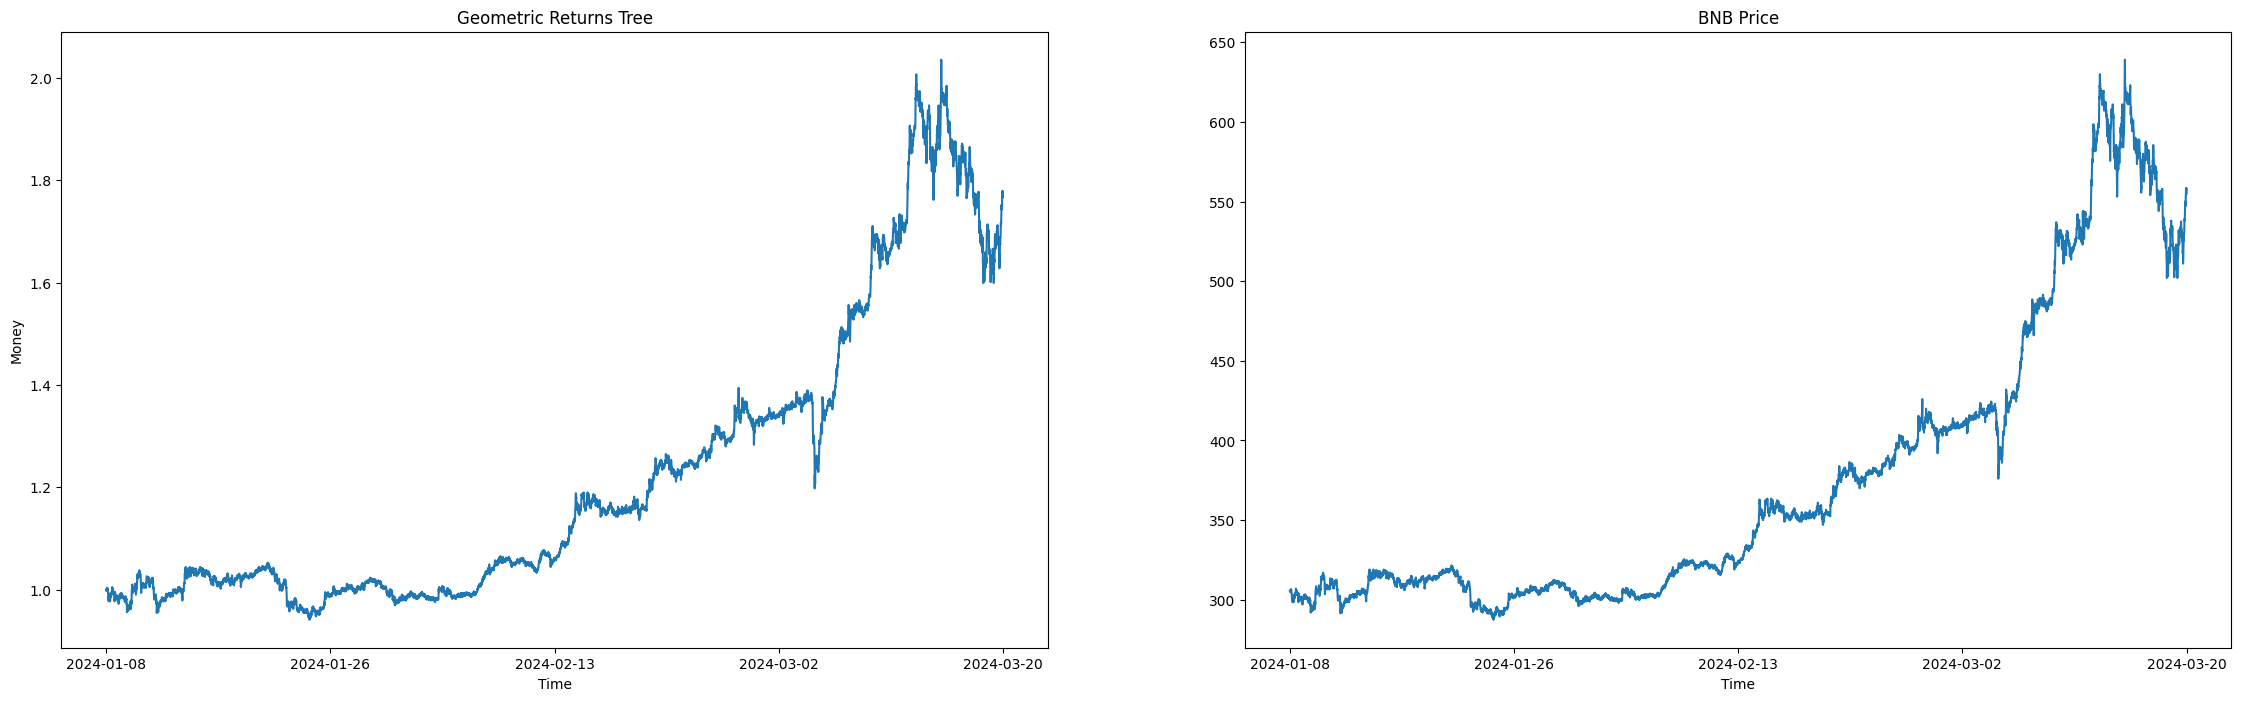

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 8))\

num_ticks = 5
ticks = np.linspace(0, len(bnb_back_test_df_tree)-1, num_ticks, dtype=int)

bnb_back_test_df_tree['Geometric_Returns_Tree'].plot(ax=axes[0], title='Geometric Returns Tree', xlabel='Time', ylabel='Money')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels([bnb_back_test_df_tree.index[i].split(' ')[0] for i in ticks])

bnb_back_test_df_tree['close'].plot(ax=axes[1], title='BNB Price', xlabel='Time')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([bnb_back_test_df_tree.index[i].split(' ')[0] for i in ticks])


plt.show()

на левом графике изменение капитала с течением времени, на правом изменение цены. судя по графику алгоритму удалось увеличить капитал в х2 раза

однако алгоритм стал приносить убыток, когда произошла коррекция рынка

In [36]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)

In [37]:
preds_bnb_forest, acc_score_bnb_forest, y_scores_bnb_forest = ML(forest, X_train_bnb, x_test_bnb, y_train_bnb, y_test_bnb)

# Выводим результаты
print('точность предсказаний (accuracy_score):', acc_score_bnb_forest)
print('количество сигналов на покупку:', preds_bnb_forest.sum())

точность предсказаний (accuracy_score): 0.38061534017044635
количество сигналов на покупку: 6923


In [38]:
bnb_back_test_df['pred_Forest'] = preds_bnb_forest
bnb_back_test_df['signal_Forest'] = (bnb_back_test_df['pred_Forest']*2) - 1
bnb_back_test_df

,close,y,pred_Tree,signal_Tree,Return_Tree,Strategy_Returns_Tree,Geometric_Returns_Tree,pred_Forest,signal_Forest
date_time,,,,,,,,,
2024-01-08 20:30:00,305.5,305.5,1,1,NaN,NaN,NaN,1,1
2024-01-08 20:45:00,305.0,305.0,1,1,-0.001637,-0.001637,0.998363,1,1
2024-01-08 21:00:00,305.5,305.5,1,1,0.001639,0.001639,1.000000,1,1
2024-01-08 21:15:00,305.5,305.5,1,1,0.000000,0.000000,1.000000,1,1
2024-01-08 21:30:00,306.0,306.0,1,1,0.001637,0.001637,1.001637,1,1
...,...,...,...,...,...,...,...,...,...
2024-03-20 22:00:00,558.5,558.5,1,1,0.006306,0.006306,1.779341,1,1
2024-03-20 22:15:00,555.5,555.5,1,1,-0.005372,-0.005372,1.769783,1,1
2024-03-20 22:30:00,554.5,554.5,1,1,-0.001800,-0.001800,1.766597,1,1


In [40]:
bnb_back_test_df_forest, bnb_geometric_returns = strategy_return(bnb_back_test_df, 'Forest')
bnb_back_test_df_forest

,close,y,pred_Tree,signal_Tree,Return_Tree,Strategy_Returns_Tree,Geometric_Returns_Tree,pred_Forest,signal_Forest,Return_Forest,Strategy_Returns_Forest,Geometric_Returns_Forest
date_time,,,,,,,,,,,,
2024-01-08 20:30:00,305.5,305.5,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN
2024-01-08 20:45:00,305.0,305.0,1,1,-0.001637,-0.001637,0.998363,1,1,-0.001637,-0.001637,0.998363
2024-01-08 21:00:00,305.5,305.5,1,1,0.001639,0.001639,1.000000,1,1,0.001639,0.001639,1.000000
2024-01-08 21:15:00,305.5,305.5,1,1,0.000000,0.000000,1.000000,1,1,0.000000,0.000000,1.000000
2024-01-08 21:30:00,306.0,306.0,1,1,0.001637,0.001637,1.001637,1,1,0.001637,0.001637,1.001637
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20 22:00:00,558.5,558.5,1,1,0.006306,0.006306,1.779341,1,1,0.006306,0.006306,1.828151
2024-03-20 22:15:00,555.5,555.5,1,1,-0.005372,-0.005372,1.769783,1,1,-0.005372,-0.005372,1.818331
2024-03-20 22:30:00,554.5,554.5,1,1,-0.001800,-0.001800,1.766597,1,1,-0.001800,-0.001800,1.815057


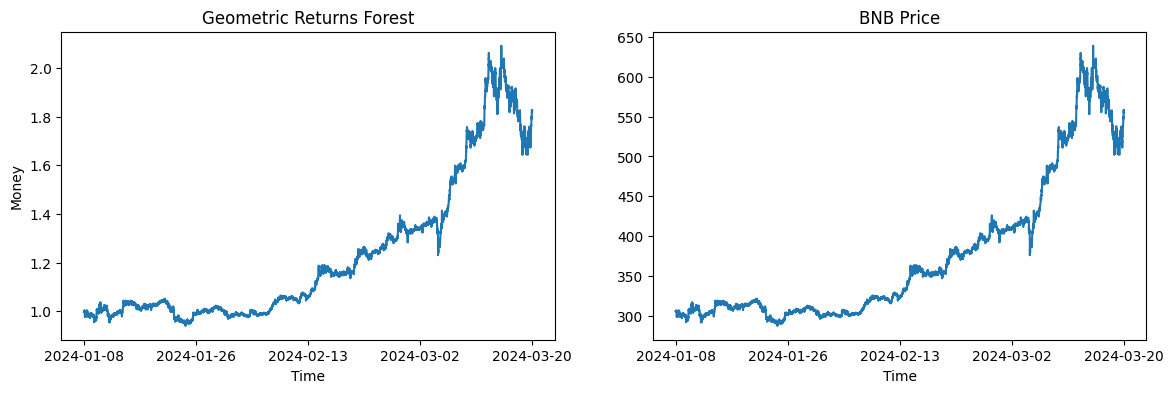

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

num_ticks = 5
ticks = np.linspace(0, len(bnb_back_test_df_forest)-1, num_ticks, dtype=int)

# График для доходности
bnb_back_test_df_forest['Geometric_Returns_Forest'].plot(ax=axes[0], title='Geometric Returns Forest', xlabel='Time', ylabel='Money')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels([bnb_back_test_df_forest.index[i].split(' ')[0] for i in ticks])

# График для изменения цены BNB
bnb_back_test_df_forest['close'].plot(ax=axes[1], title='BNB Price', xlabel='Time')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([bnb_back_test_df_forest.index[i].split(' ')[0] for i in ticks])

plt.show()


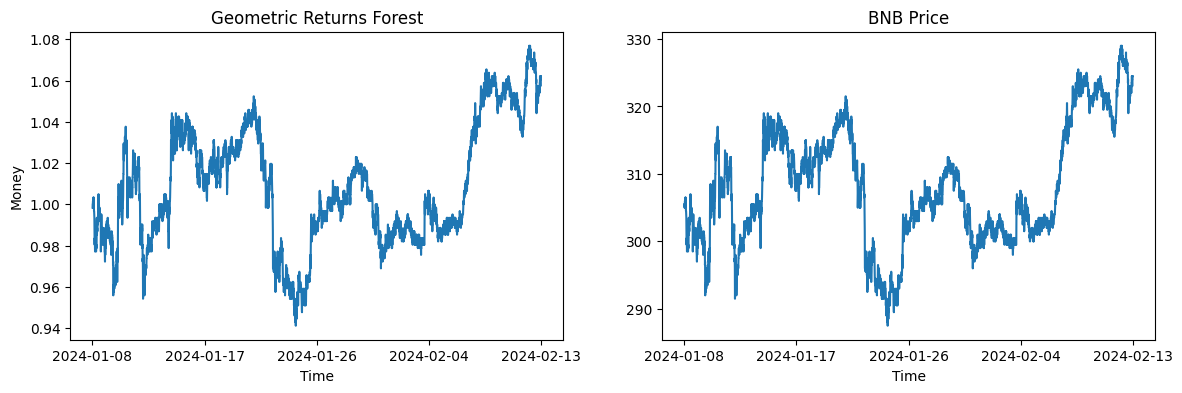

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

end_time = '2024-02-13 23:00:00'
end_index = bnb_back_test_df_forest.index.get_loc(end_time)

num_ticks = 5
ticks = np.linspace(0, end_index, num_ticks, dtype=int)

# График для доходности
bnb_back_test_df_forest.iloc[:end_index]['Geometric_Returns_Forest'].plot(ax=axes[0], title='Geometric Returns Forest', xlabel='Time', ylabel='Money')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels([bnb_back_test_df_forest.index[i].split(' ')[0] for i in ticks])

# Создаем новый DataFrame для цены BNB
bnb_price_df = bnb_back_test_df_forest[['close']].copy()

# График для цены BNB
bnb_price_df.iloc[:end_index]['close'].plot(ax=axes[1], title='BNB Price', xlabel='Time')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([bnb_back_test_df_forest.index[i].split(' ')[0] for i in ticks])

plt.show()

